In [1]:
!pip install pm4py
!pip install optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.8 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=5af165ae2713667e45fc57e3aa4bdd464c4639c93d5e5dfdd122970f34debcfb
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [2]:
log_url = "https://data.4tu.nl/datasets/6a0a26d2-82d0-4018-b1cd-89afb0e8627f"

In [15]:
import pm4py
import optuna
import pandas as pd
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristic_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.check_soundness import check_easy_soundness_net_in_fin_marking
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.statistics.traces.generic.pandas import case_statistics

In [14]:
# Domestic declarations log
log = pm4py.read_xes('DomesticDeclarations.xes')

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [8]:
# Italian helpdesk log
data = pd.read_csv('finale.csv')
data.rename(columns={
    'Case ID': 'case:concept:name',
    'Activity': 'concept:name',
    'Complete Timestamp': 'time:timestamp'
}, inplace=True)

# Convert the timestamp column to datetime format
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])

# Ensure the activity names are treated as strings
data['concept:name'] = data['concept:name'].astype(str)
log = log_converter.apply(data, variant=log_converter.Variants.TO_EVENT_LOG)

In [5]:
log

[{'attributes': {'concept:name': 'Case 1'}, 'events': [{'concept:name': 'Assign seriousness', 'Resource': 'Value 1', 'time:timestamp': Timestamp('2012-10-09 14:50:17'), 'Variant': 'Variant 12', 'Variant index': 12, 'Variant.1': 'Variant 12', 'seriousness': 'Value 1', 'customer': 'Value 1', 'product': 'Value 1', 'responsible_section': 'Value 1', 'seriousness_2': 'Value 1', 'service_level': 'Value 1', 'service_type': 'Value 1', 'support_section': 'Value 1', 'workgroup': 'Value 1'}, '..', {'concept:name': 'Closed', 'Resource': 'Value 3', 'time:timestamp': Timestamp('2012-11-09 12:54:39'), 'Variant': 'Variant 12', 'Variant index': 12, 'Variant.1': 'Variant 12', 'seriousness': 'Value 1', 'customer': 'Value 1', 'product': 'Value 1', 'responsible_section': 'Value 1', 'seriousness_2': 'Value 1', 'service_level': 'Value 2', 'service_type': 'Value 1', 'support_section': 'Value 1', 'workgroup': 'Value 1'}]}, '....', {'attributes': {'concept:name': 'Case 4580'}, 'events': [{'concept:name': 'Take i

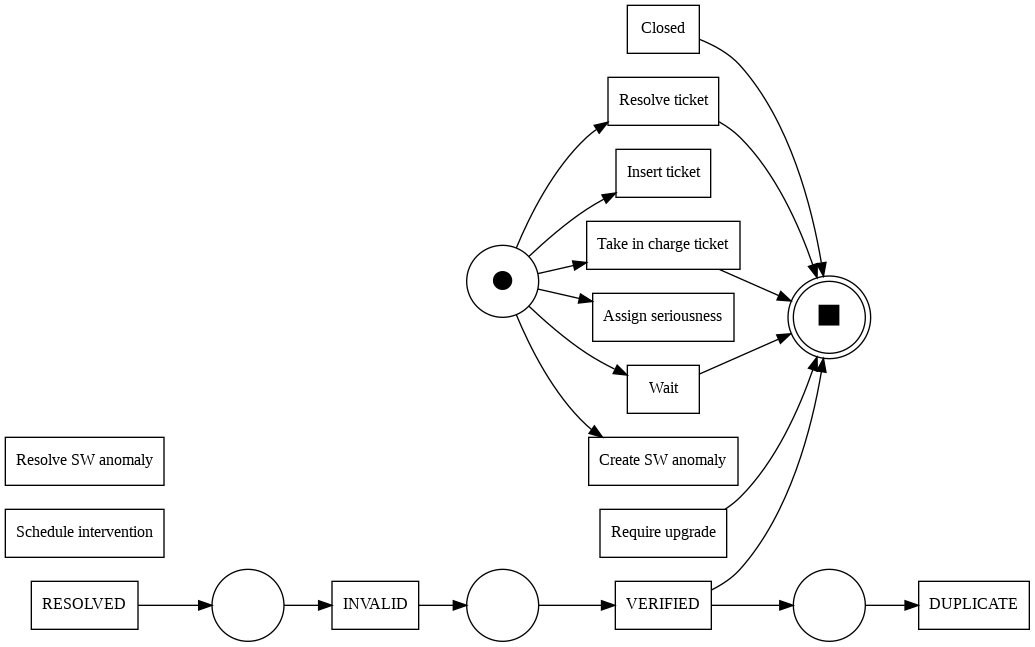

In [6]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

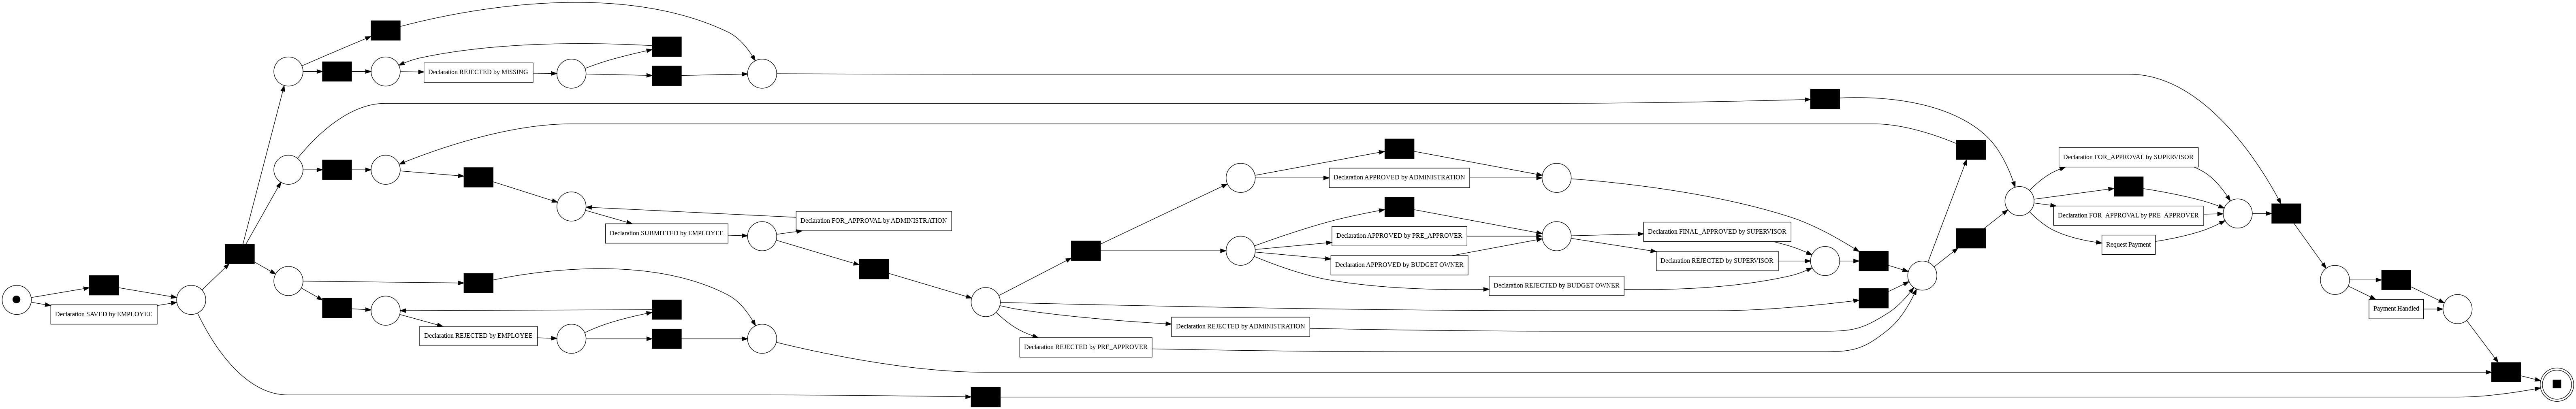

In [12]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

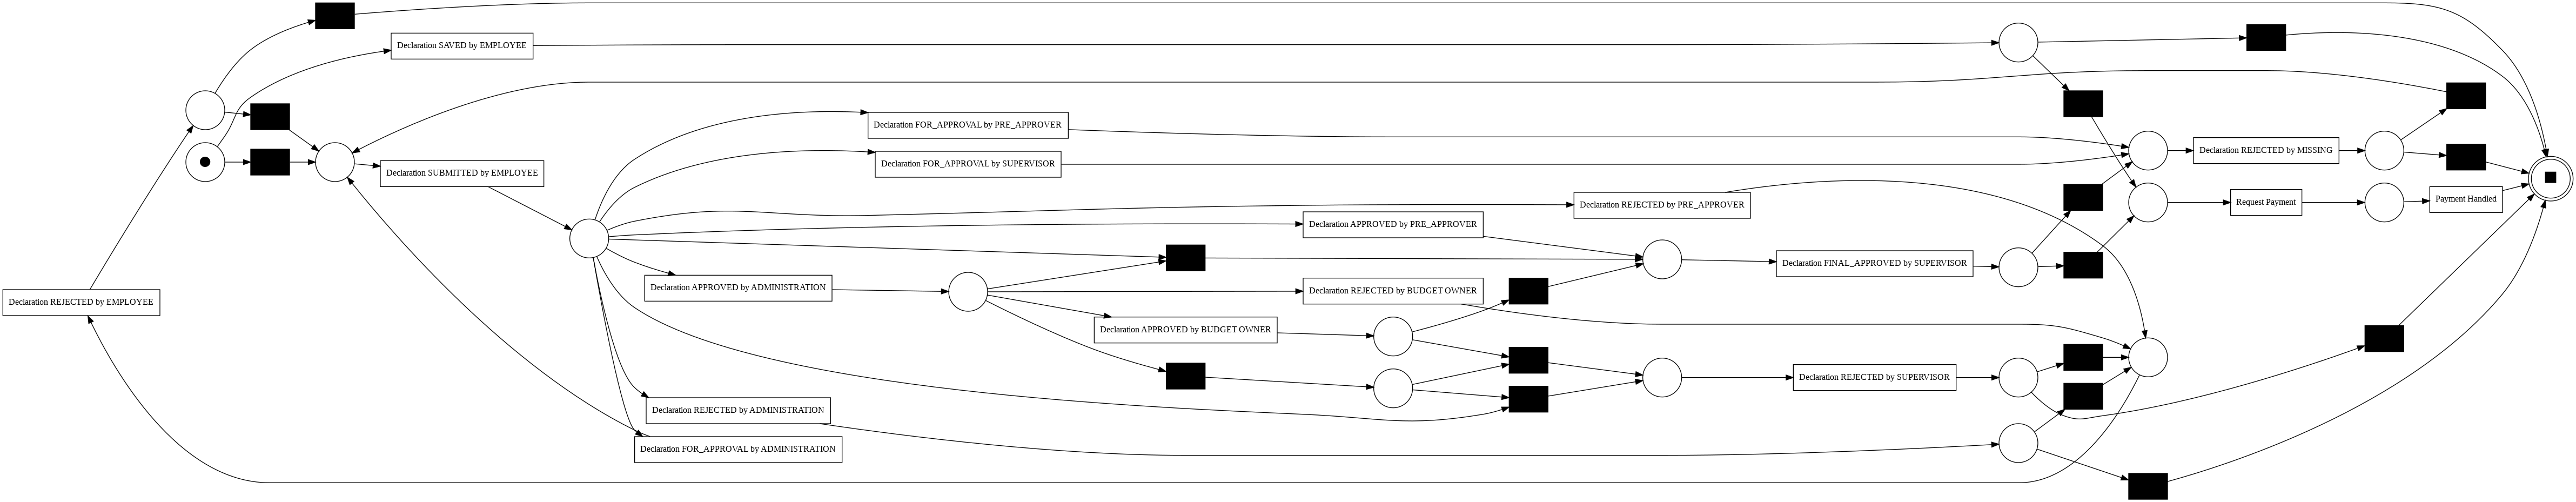

In [13]:
net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

In [16]:
"""
Functions for evaluation
"""

def evaluate_fitness(net, initial_marking, final_marking, log):
    # Check if the produced net has sound structure or not
    is_sound = check_easy_soundness_net_in_fin_marking(net, initial_marking, final_marking)

    if is_sound:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.ALIGNMENT_BASED
        )
    else:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.TOKEN_BASED
        )

    return fitness_results["log_fitness"]

def evaluate_simplicity(net, weight_places=1, weight_transitions=2, weight_arcs=1):
    """
    Evaluates simplicity of a Petri net based on its structural complexity.

    Parameters:
        net: The Petri net object.
        weight_places: Weight for places in the simplicity calculation.
        weight_transitions: Weight for transitions in the simplicity calculation.
        weight_arcs: Weight for arcs in the simplicity calculation.

    Returns:
        A simplicity score (higher is simpler).
    """
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)

    # Weighted simplicity calculation
    complexity = (
        weight_places * num_places +
        weight_transitions * num_transitions +
        weight_arcs * num_arcs
    )
    simplicity = 1 / (complexity + 1)  # Avoid division by zero
    return simplicity

def evaluate_generalization(net, initial_marking, final_marking, log):
    # Trace coverage
    replay_results = token_replay.apply(log, net, initial_marking, final_marking)
    fully_replayed = sum(1 for res in replay_results if res['trace_is_fit'])
    trace_coverage = fully_replayed / len(replay_results) if replay_results else 0

    # Model complexity vs. log variability
    unique_traces = case_statistics.get_variant_statistics(log)
    num_unique_traces = len(unique_traces)
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)
    model_complexity = num_places + num_transitions + num_arcs
    variability_ratio = num_unique_traces / (model_complexity + 1)

    # Weighted generalization score
    generalization = (trace_coverage * 0.6) + (variability_ratio * 0.4)
    return generalization

In [17]:
def apply_alpha(log):
    net, initial_marking, final_marking = alpha_miner.apply(log)
    return net, initial_marking, final_marking

def apply_heuristic(log, parameters):
    net, initial_marking, final_marking = heuristic_miner.apply(log, parameters=parameters)
    return net, initial_marking, final_marking

def apply_inductive(log, noise_threshold=0.0):
    parameters = {"noise_threshold": noise_threshold}
    process_tree = inductive_miner.apply(log, parameters=parameters)

    # Convert the Process Tree to a Petri net
    net, initial_marking, final_marking = pt_converter.apply(process_tree)
    return net, initial_marking, final_marking

In [20]:
def objective(trial):
    # Select an algorithm
    algorithm = trial.suggest_categorical("algorithm", ["alpha", "heuristic", "inductive"])

    # Apply the selected algorithm
    if algorithm == "alpha":
        net, initial_marking, final_marking = apply_alpha(log)
    elif algorithm == "heuristic":
        dependency_thresh = trial.suggest_float("dependency_thresh", 0.0, 1.0)
        and_measure_thresh = trial.suggest_float("and_measure_thresh", 0.5, 1.0)
        loop_two_thresh = trial.suggest_float("loop_two_thresh", 0.0, 1.0)
        parameters = {
        "dependency_thresh": dependency_thresh,
        "and_measure_thresh": and_measure_thresh,
        "loop_two_thresh": loop_two_thresh
        }
        net, initial_marking, final_marking = apply_heuristic(log, parameters=parameters)
    elif algorithm == "inductive":
        noise_threshold = trial.suggest_float("noise_threshold", 0.0, 0.3)
        net, initial_marking, final_marking = apply_inductive(log, noise_threshold=noise_threshold)

    # Evaluate metrics
    fitness = evaluate_fitness(net, initial_marking, final_marking, log)
    simplicity = evaluate_simplicity(net)
    generalization = evaluate_generalization(net, initial_marking, final_marking, log)

    # Combine metrics (weighted sum as an example)
    combined_score = fitness * 0.6 + simplicity * 0.2 + generalization * 0.2
    return combined_score

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-12-14 14:27:18,129] A new study created in memory with name: no-name-d3fea56d-1f20-4cbc-ae3b-0ad8cbe8848c


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:23,943] Trial 0 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.27983628900771707}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:27,475] Trial 1 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.3511629669056302, 'and_measure_thresh': 0.578589926606312, 'loop_two_thresh': 0.9369964191888831}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:33,856] Trial 2 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2473573480643826}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:35,968] Trial 3 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:41,094] Trial 4 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.18178645665927728}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:45,078] Trial 5 finished with value: 0.6804436791346526 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.019110145085731944, 'and_measure_thresh': 0.5211995416594841, 'loop_two_thresh': 0.08189635301775489}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:49,263] Trial 6 finished with value: 0.6585010590953313 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.6684236781840468, 'and_measure_thresh': 0.7980733929241627, 'loop_two_thresh': 0.8237275053516228}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:54,561] Trial 7 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.08630796582344631}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:27:56,896] Trial 8 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:00,521] Trial 9 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:05,796] Trial 10 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.29366907154454297}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:13,726] Trial 11 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2860699673369104}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:19,310] Trial 12 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.20883747025204089}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:24,534] Trial 13 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.23039012478644322}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:31,188] Trial 14 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.12448110527922135}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:36,274] Trial 15 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2499616081061226}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:43,205] Trial 16 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.015087660383902274}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:49,378] Trial 17 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.24969632974038586}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:51,582] Trial 18 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:28:54,690] Trial 19 finished with value: 0.6882182355151022 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.9883320222225165, 'and_measure_thresh': 0.9511787133318953, 'loop_two_thresh': 0.0794125040261141}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:01,075] Trial 20 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1632799923673217}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:06,273] Trial 21 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.18391510884330334}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:13,224] Trial 22 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2578000127156143}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:18,418] Trial 23 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1919275340285324}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:24,100] Trial 24 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2929320702608426}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:30,448] Trial 25 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.13014189855188155}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:35,440] Trial 26 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.22135916161327882}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:41,696] Trial 27 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2626386519501131}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:45,421] Trial 28 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.012624748102113337, 'and_measure_thresh': 0.9839307988372163, 'loop_two_thresh': 0.509450819327649}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:47,968] Trial 29 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:51,830] Trial 30 finished with value: 0.690486255744215 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.9890519551456614, 'and_measure_thresh': 0.7091553690996142, 'loop_two_thresh': 0.44925527024057993}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:29:58,181] Trial 31 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.09590751465567435}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:04,147] Trial 32 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.06546815050625289}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:11,395] Trial 33 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.0519852019993208}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:16,842] Trial 34 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.15465075570931702}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:19,971] Trial 35 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:24,718] Trial 36 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.4267500222367344, 'and_measure_thresh': 0.8063345806594767, 'loop_two_thresh': 0.5682330255963028}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:30,720] Trial 37 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.09937441504174035}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:37,518] Trial 38 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.17470357502111344}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:39,988] Trial 39 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:45,634] Trial 40 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.20506246299127262}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:52,279] Trial 41 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2969664895079462}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:30:57,832] Trial 42 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.27455806484151324}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:31:04,497] Trial 43 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.24104881178638832}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:31:09,979] Trial 44 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.27129193266975404}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:31:15,799] Trial 45 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.281351200050111}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:31:22,029] Trial 46 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2997147651590038}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:31:25,609] Trial 47 finished with value: 0.6585010590953313 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.663073221514522, 'and_measure_thresh': 0.6622762613372324, 'loop_two_thresh': 0.2564910926264128}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:31:32,199] Trial 48 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1296777998429198}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-14 14:31:37,420] Trial 49 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.22686612586257313}. Best is trial 0 with value: 0.7697161312897309.


Best algorithm and parameters:
{'algorithm': 'inductive', 'noise_threshold': 0.27983628900771707}


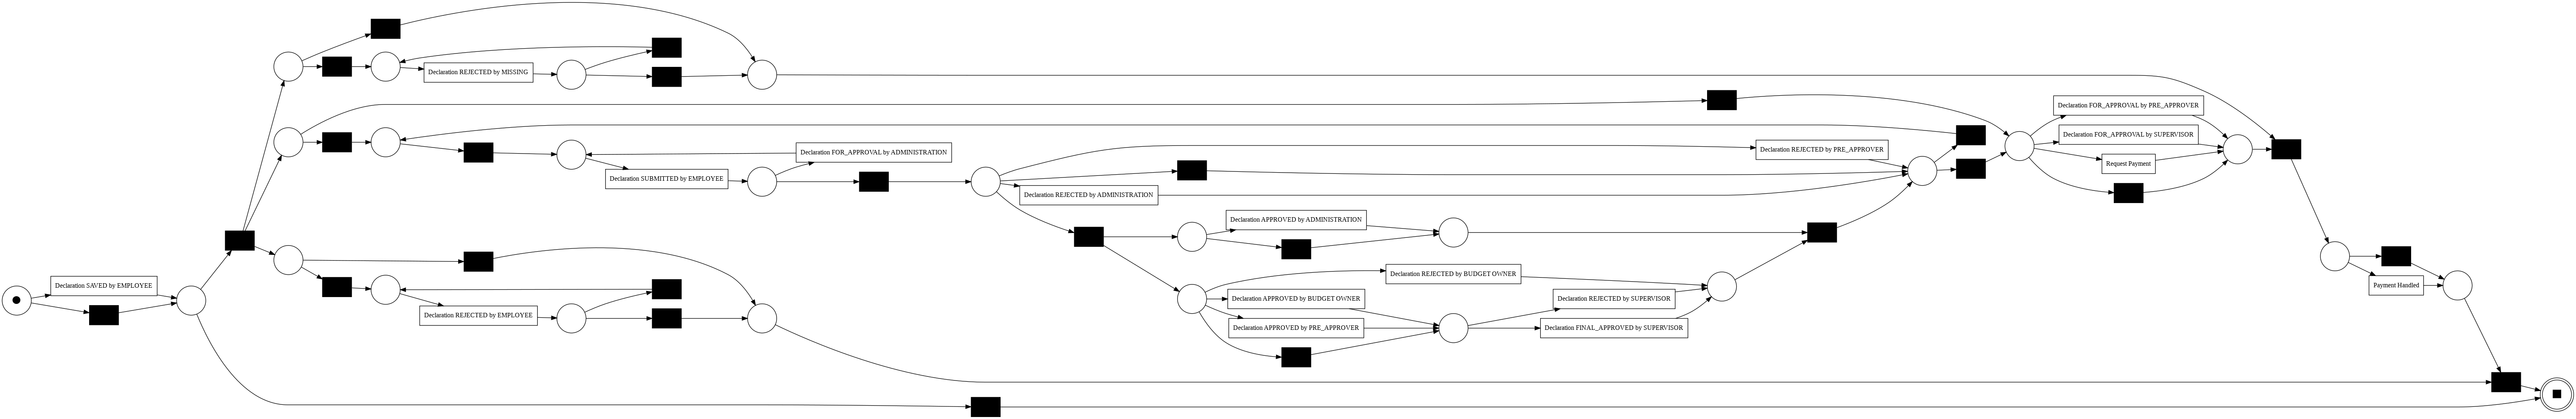

In [22]:
print("Best algorithm and parameters:")
print(study.best_params)

# Apply the best model to get the final process model
best_algorithm = study.best_params["algorithm"]
if best_algorithm == "alpha":
    final_net, final_initial_marking, final_final_marking = apply_alpha(log)
elif best_algorithm == "heuristic":
    best_dependency_thresh = study.best_params["dependency_thresh"]
    final_net, final_initial_marking, final_final_marking = apply_heuristic(log, dependency_thresh=best_dependency_thresh)
elif best_algorithm == "inductive":
    best_noise_threshold = study.best_params["noise_threshold"]
    final_net, final_initial_marking, final_final_marking = apply_inductive(log, noise_threshold=best_noise_threshold)

# Visualize the best model
gviz = pn_visualizer.apply(final_net, final_initial_marking, final_final_marking)
pn_visualizer.view(gviz)